In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

In [2]:
# Experiment settings
num_epochs = 100
num_classes = 10
batch_size = 256
learning_rate = 0.01

np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
'''ResNet in PyTorch.

The script (in this cell) is based on https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385

MIT License

Copyright (c) 2017 liukuang

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

'''

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        # Add dropout layer to overcome overfitting
        self.drop_out = nn.Dropout(p=0.5)
        self.init_weights()
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    # Add initialization functions
    def init_weights(self):
        """Function for weight initialization
        """
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                layer.bias.data.fill_(0.1)
            elif isinstance(layer, nn.Conv2d):
                nn.init.xavier_uniform_(layer.weight)
                
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.drop_out(out)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])

In [4]:
# Transform pixel value to [0,1], data augmentation and normalize.
transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

transform_test = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Create data loader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, drop_last=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=True, num_workers=2, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
def train(model, flooding_b=0.1):
    # Loss function and optimizer
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5, momentum=0.9)    
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 50, 90])
    
    # A dictionary to store results
    history = {'train_loss':[], 'test_loss':[], 'train_acc':[], 'test_acc':[]}
    
    for epoch in range(num_epochs):
        train_acc = []
        test_acc = []
        train_loss = []
        test_loss = []
        model.train()
        for i, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() 
            
            # Forward pass
            outputs = model(images)
            
            # calculate loss and accuracy
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size()[0]
            correct = predicted.eq(labels.data).sum()
            acc = correct / total

            # Backward and optimize
            loss = criterion(outputs, labels)
            loss = abs(loss - flooding_b) + flooding_b
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_acc.append(acc.cpu())
            
        history['train_loss'].append(np.mean(train_loss))
        history['train_acc'].append(np.mean(train_acc))
            

        model.eval()
        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                
                # calculate accuracy
                total = labels.size()[0]
                correct = predicted.eq(labels.data).sum()
                acc = correct / total
                
                # calculate loss
                loss = criterion(outputs, labels)
                test_loss.append(loss.item())
                test_acc.append(acc.cpu())
             
            history['test_loss'].append(np.mean(test_loss))
            history['test_acc'].append(np.mean(test_acc))
            
        scheduler.step()
        
        print(f'Epoch: {epoch}, train loss: {np.mean(train_loss)}')
        print(f'Epoch: {epoch}, test loss: {np.mean(test_loss)}')
        
    return history

In [7]:
model = ResNet18().to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

In [ ]:
# `his_b0` saves results for flooding_constant = 0
his_b0 = train(model, flooding_b=0)

In [ ]:
# `his_b0` saves results for flooding_constant = 0.1
model = ResNet18().to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
his_b1 = train(model, flooding_b=0.1)

Text(0.5, 1.0, 'ResNet18-CIFAR10')

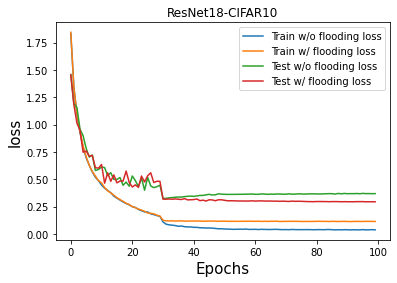

In [18]:
fig, ax = plt.subplots()
ax.plot(his_b0['train_loss'], label="Train w/o flooding loss")
ax.plot(his_b1['train_loss'], label="Train w/ flooding loss")
ax.plot(his_b0['test_loss'], label="Test w/o flooding loss")
ax.plot(his_b1['test_loss'], label="Test w/ flooding loss")

ax.legend()
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('loss', fontsize=15)  
ax.set_title('ResNet18-CIFAR10')

Text(0.5, 1.0, 'ResNet18-CIFAR10')

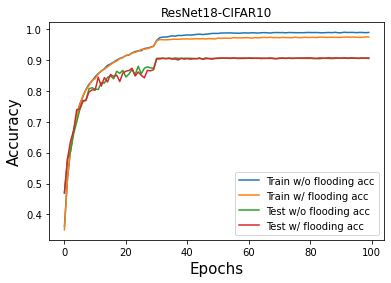

In [25]:
fig, ax = plt.subplots()
ax.plot(his_b0['train_acc'], label="Train w/o flooding acc")
ax.plot(his_b1['train_acc'], label="Train w/ flooding acc")
ax.plot(his_b0['test_acc'], label="Test w/o flooding acc")
ax.plot(his_b1['test_acc'], label="Test w/ flooding acc")

ax.legend()
ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)  
ax.set_title('ResNet18-CIFAR10')